<a href="https://colab.research.google.com/github/Dana1402/course-work-cnn/blob/main/FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import

In [ ]:
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras import models
from keras import layers
import shutil
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
import warnings
warnings.simplefilter('ignore')

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Чистим папку, если чт-то пошло не так
shutil.rmtree('/content/drive/MyDrive/com_vision/train')

### Create DataFrame

In [ ]:
# !cd /content/drive/MyDrive/com_vision && unzip -q train.zip

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/com_vision/train.csv')

In [ ]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [ ]:
class_weight = {}
for i, j  in enumerate(set(df.emotion)):
    count_of_samples = df[df['emotion'] == j].agg('count')[0]
    total = df.shape[0]
    weight = (1 / count_of_samples) * (total / 9.0)

    class_weight[i] = weight

In [ ]:
class_weight

{0: 1.7624933967247756,
 1: 1.8024851431658562,
 2: 0.933781136300028,
 3: 1.1024319323288396,
 4: 0.8794348674152566,
 5: 0.825024727992087,
 6: 0.8183468236448369,
 7: 0.7918921484857117,
 8: 0.938192452617963}

In [ ]:
# преобразуем имена файлов(убрать все кроме имени)
for i in range(len(df)):  
    df['image_path'][i] = df['image_path'][i].replace("./train/", "")

In [ ]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,anger/0.jpg,anger
1,1,anger/1.jpg,anger
2,2,anger/10.jpg,anger
3,3,anger/100.jpg,anger
4,4,anger/1000.jpg,anger


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df.iloc[:,0:2], df['emotion'], test_size=0.2, stratify=df['emotion'])

In [ ]:
train = pd.concat([train_x, train_y], axis = 1).reset_index(drop=True)
test = pd.concat([test_x, test_y], axis = 1).reset_index(drop=True)

In [ ]:
# Делаем one-hot encoding
ohe = OneHotEncoder(sparse = False)
new_one_features = ohe.fit_transform(train.emotion.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['emotion=' + str(i) for i in range(new_one_features.shape[1])])
df3_train = pd.concat([train, tmp], axis = 1)

In [ ]:
# Делаем one-hot encoding
ohe = OneHotEncoder(sparse = False)
new_one_features = ohe.fit_transform(test.emotion.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['emotion=' + str(i) for i in range(new_one_features.shape[1])])
df3_test = pd.concat([test, tmp], axis = 1)

In [ ]:
def load_image(path):
    """
    function to download an image from a directory
    """  
    img = image.load_img(path)
    img = (np.array(img).astype(float))/255 #convert to array and scale 0..255 to 0..1
    img = np.expand_dims(img, axis = 0)
    tf.image.adjust_contrast(img, contrast_factor)
#     preprocessed_input = tf.keras.applications.vgg16.preprocess_input(img*255.)
    return img

In [ ]:
from tensorflow.keras.preprocessing import image
img = load_image('C:/Users/Admin/Documents/курсовая_нейронка_эмоции/train/train/anger/1000.jpg')
# plt.imshow(np.squeeze(img, axis = 0))
preprocessed_input = tf.keras.applications.vgg16.preprocess_input(img*255.)
plt.imshow(np.squeeze(preprocessed_input, axis = 0))

### DataGenerator

In [ ]:
def preprocessing_image(image):
    img = (np.array(img).astype(float))/255 #convert to array and scale 0..255 to 0..1
    img = np.expand_dims(img, axis = 0)
    preprocessed_input = tf.keras.applications.vgg16.preprocess_input(img*255.)
    return img

In [ ]:
datagen = ImageDataGenerator(preprocessing_image)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=20,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.01,
                            zoom_range=0.1,
# #                             horizontal_flip=True,
                            fill_mode='nearest',
                            preprocessing_function=load_image
                             )

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


### VGGFace

Используем предобученную VGGFace, так как уже обучена на лицах людей.

In [ ]:
# Most Recent One (Suggested)
!pip install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
!pip install keras_vggface

  Cloning https://github.com/rcmalli/keras-vggface.git to c:\users\admin\appdata\local\temp\pip-req-build-svufwquj


  Running command git clone -q https://github.com/rcmalli/keras-vggface.git 'C:\Users\Admin\AppData\Local\Temp\pip-req-build-svufwquj'


In [ ]:
# !pip install git+https://github.com/rcmalli/keras-vggface.git
# !pip install keras_applications --no-deps
filename = "E:/anaconda/Lib/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [ ]:
base_model = VGGFace(weights='vggface', include_top=False, input_shape=(128,128,3), pooling='max')

In [ ]:
base_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 128, 128, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 128, 128, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 64, 64, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 64, 64, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 128)     

In [ ]:
base_model.trainable = False

fine_tune_at = 17
# # # все слои до -- заморозим
for layer in base_model.layers[:16]:
    layer.trainable =  False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512,   kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 activity_regularizer=regularizers.L2(1e-4),
                       activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 512)               14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 14,981,961
Trainable params: 267,273
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'Adam',
              loss = tf.keras.losses.CategoricalCrossentropy(1e-4),
              metrics = ['categorical_accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main3_vggface.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

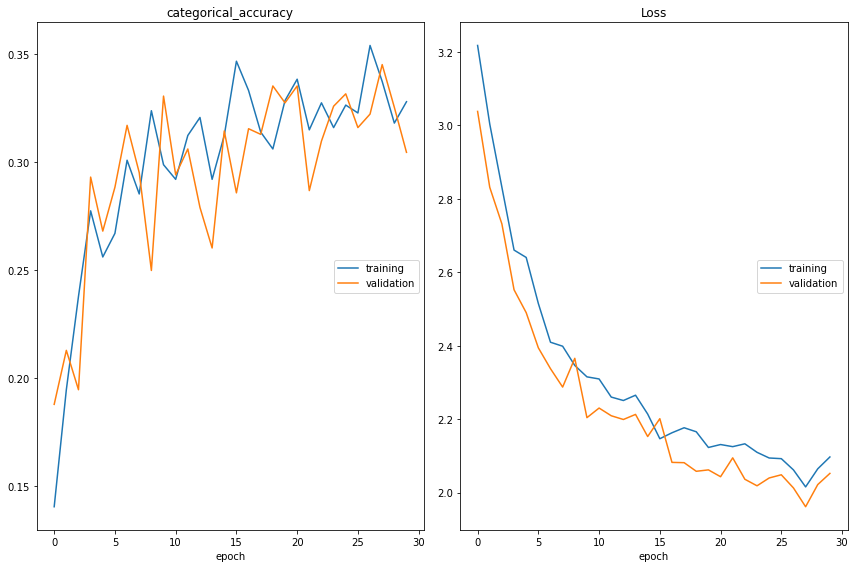

categorical_accuracy
	training         	 (min:    0.141, max:    0.354, cur:    0.328)
	validation       	 (min:    0.188, max:    0.345, cur:    0.305)
Loss
	training         	 (min:    2.016, max:    3.218, cur:    2.097)
	validation       	 (min:    1.962, max:    3.038, cur:    2.052)
30/30 [==============================] - 405s 14s/step - loss: 2.0972 - categorical_accuracy: 0.3281 - val_loss: 2.0524 - val_categorical_accuracy: 0.3047


In [ ]:
history = model.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 30,
                      validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback,
                                   early_stopping_callback],
                      class_weight=class_weight)

### VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
#Load the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def preprocessing_image_vgg16(image):
    img = (np.array(img).astype(float))/255 #convert to array and scale 0..255 to 0..1
    img = np.expand_dims(img, axis = 0)
    preprocessed_input = tf.keras.applications.vgg16.preprocess_input(img*255.)
    return img

In [ ]:
datagen = ImageDataGenerator(preprocessing_image_vgg16,
#                              rotation_range=20,
#                             width_shift_range=0.1,
#                             height_shift_range=0.1,
#                             shear_range=0.01,
#                             zoom_range=0.1,
# #                             horizontal_flip=True,
#                             fill_mode='nearest'
                            )

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable = False
 # Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002310EB86F70> False
<keras.layers.convolutional.Conv2D object at 0x000002310CE20EE0> False
<keras.layers.convolutional.Conv2D object at 0x000002310C402D30> False
<keras.layers.pooling.MaxPooling2D object at 0x000002310CE20A90> False
<keras.layers.convolutional.Conv2D object at 0x000002310F601310> False
<keras.layers.convolutional.Conv2D object at 0x000002310F601850> False
<keras.layers.pooling.MaxPooling2D object at 0x000002310F5FABB0> False
<keras.layers.convolutional.Conv2D object at 0x000002310F60C910> False
<keras.layers.convolutional.Conv2D object at 0x000002310F615820> False
<keras.layers.convolutional.Conv2D object at 0x000002310F615940> False
<keras.layers.pooling.MaxPooling2D object at 0x000002310F615BB0> False
<keras.layers.convolutional.Conv2D object at 0x000002310F61C1C0> False
<keras.layers.convolutional.Conv2D object at 0x000002310F623D60> False
<keras.layers.convolutional.Conv2D object at 0x000002310F61A160> False
<ker

In [ ]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(base_model)
 
# Add new layers
#     model.add(tf.keras.layers.Conv2D(512, (3,3), activation = 'relu'))
#     model.add(tf.keras.layers.Conv2D(512, (3,3), activation = 'relu'))
#     model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, 
                                 kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 activity_regularizer=regularizers.L2(1e-4),
                                activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(9, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 21,139,785
Trainable params: 11,144,713
Non-trainable params: 9,995,072
_________________________________________________________________


In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main3_imagenet_augm.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

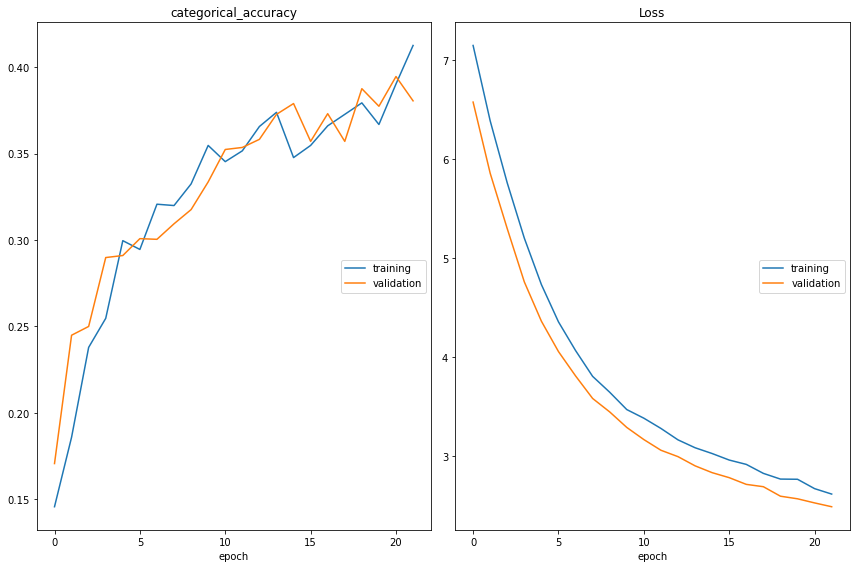

categorical_accuracy
	training         	 (min:    0.146, max:    0.412, cur:    0.412)
	validation       	 (min:    0.171, max:    0.395, cur:    0.380)
Loss
	training         	 (min:    2.613, max:    7.149, cur:    2.613)
	validation       	 (min:    2.485, max:    6.576, cur:    2.485)
20/20 [==============================] - 1648s 84s/step - loss: 2.6132 - categorical_accuracy: 0.4125 - val_loss: 2.4851 - val_categorical_accuracy: 0.3805
Epoch 23/40
13/20 [==================>...........] - ETA: 5:07 - loss: 2.6010 - categorical_accuracy: 0.3996

In [ ]:
history = model.fit( train_generator_1,
                      steps_per_epoch=80,
                      epochs = 40,
                      validation_data = test_generator_1,
                      validation_steps = 80,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback,
                                   early_stopping_callback],
                      class_weight=class_weight)

In [ ]:
model = tf.keras.models.load_model('model_main3_imagenet_augm.h5')

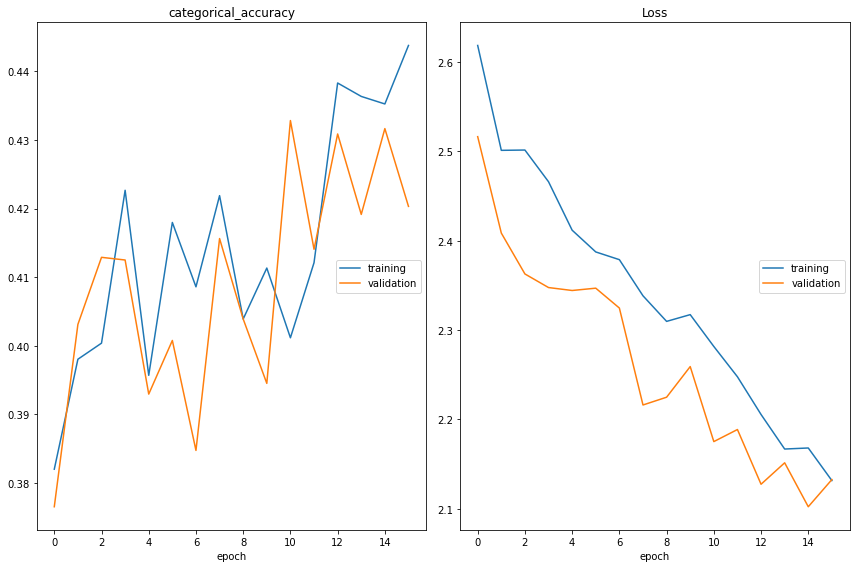

categorical_accuracy
	training         	 (min:    0.382, max:    0.444, cur:    0.444)
	validation       	 (min:    0.377, max:    0.433, cur:    0.420)
Loss
	training         	 (min:    2.132, max:    2.619, cur:    2.132)
	validation       	 (min:    2.102, max:    2.517, cur:    2.133)
20/20 [==============================] - 1852s 94s/step - loss: 2.1315 - categorical_accuracy: 0.4437 - val_loss: 2.1327 - val_categorical_accuracy: 0.4203


In [ ]:
history = model.fit( train_generator_1,
                      steps_per_epoch=20,
                      epochs = 16,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

### VGG19

In [ ]:
from tensorflow.keras.applications import VGG19

In [ ]:
#Load the VGG model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
def preprocessing_image_vgg19(image):
    img = (np.array(image).astype(float))/255 #convert to array and scale 0..255 to 0..1
    img = np.expand_dims(img, axis = 0)
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(img*255.)
    return img

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocessing_image_vgg19,
                            rotation_range=20,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.01,
                            zoom_range=0.1,
# #                           horizontal_flip=True,
                            fill_mode='nearest'
                            )

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='/content/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='/content/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable = False
 # Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7faab33b28e0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7faab377e760> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7faab377ef10> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7faab43020d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7faab41f5460> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7faab42915e0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7faab42951f0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7faab4291220> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7faab42996d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7faab42995e0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7faab42a08e0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7faab42a5700> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7faab42a5a00> False
<keras.layers.convolut

In [ ]:
def get_compiled_model():
    # Create the model
    model = models.Sequential()

    # Add the vgg convolutional base model
    model.add(base_model)

    # Add new layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, 
                                     kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                                     bias_regularizer=regularizers.L2(1e-4),
                                     activity_regularizer=regularizers.L2(1e-4),
                                    activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(9, activation='softmax'))
    
    model.compile(optimizer= 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])
    
    return model

In [ ]:
model_vgg19=get_compiled_model()

In [ ]:
model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dense_3 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 21,074,249
Trainable params: 8,129,289
Non-trainable params: 12,944,960
_________________________________________________________________


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_vgg19.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

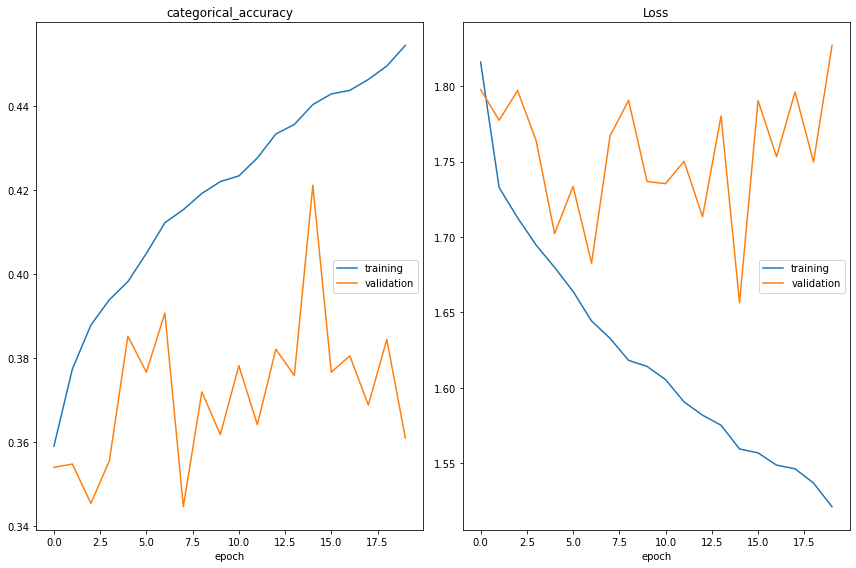

categorical_accuracy
	training         	 (min:    0.359, max:    0.454, cur:    0.454)
	validation       	 (min:    0.345, max:    0.421, cur:    0.361)
Loss
	training         	 (min:    1.521, max:    1.816, cur:    1.521)
	validation       	 (min:    1.656, max:    1.827, cur:    1.827)
600/600 [==============================] - 428s 714ms/step - loss: 1.5211 - categorical_accuracy: 0.4544 - val_loss: 1.8271 - val_categorical_accuracy: 0.3609
Epoch 21/50
469/600 [======================>.......] - ETA: 1:28 - loss: 1.5010 - categorical_accuracy: 0.4615


KeyboardInterrupt



In [ ]:
%%time
history = model_vgg19.fit( train_generator_1,
                      steps_per_epoch=600,
                      epochs = 50,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback,
                                   early_stopping_callback],
                      class_weight=class_weight)

### DenseNet201

In [ ]:
from keras.applications.densenet import DenseNet201

In [ ]:
densenet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
def preprocessing_image_densenet(image):
    img = (np.array(image).astype(float))/255 #convert to array and scale 0..255 to 0..1
    img = np.expand_dims(img, axis = 0)
    preprocessed_input = tf.keras.applications.densenet.preprocess_input(img*255.)
    return img

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocessing_image_densenet,
                            rotation_range=20,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.01,
                            zoom_range=0.1,
# #                           horizontal_flip=True,
                            fill_mode='nearest'
                            )

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='/content/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='/content/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=64)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


[1. 0. 0. 0. 0. 0. 0. 0. 0.]


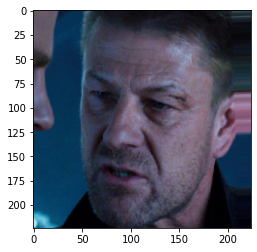

In [ ]:
sample = next(train_generator_1)
print(sample[1][3])
# print(np.split(sample[1][3].astype("float32"), 3, axis=1))
plt.imshow(sample[0][3])

In [ ]:
for layer in densenet201.layers[:-24]:
    layer.trainable = False
 # Check the trainable status of the individual layers
for layer in densenet201.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe52d8f9a00> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fe52d8f9b20> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe54bc1ff40> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe54c0d7f40> False
<keras.layers.core.activation.Activation object at 0x7fe54c1181c0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fe546d3b070> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe4f045ff40> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe54c4e0b20> False
<keras.layers.core.activation.Activation object at 0x7fe4f0410460> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe4f0410760> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe4f046b7f0> False
<keras.layers.core.activation.Activation object at 0x7fe4f041d520> False
<keras.layers.co

In [ ]:
def get_compiled_model():
    # Create the model
    model = models.Sequential()
    # Add the vgg convolutional base model
    model.add(densenet201)

    # Add new layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, 
                                #  kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                                #  bias_regularizer=regularizers.L2(1e-4),
                                #  activity_regularizer=regularizers.L2(1e-4),
                                activation='relu'))
    # model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(9, activation='softmax'))

#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(128, use_bias=True))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Activation(activation='relu'))    
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(9, activation='softmax'))
    
    model.compile(optimizer= 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])
    
    return model

In [ ]:
model=get_compiled_model()

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_7 (Flatten)         (None, 94080)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               12042368  
                                                                 
 dense_15 (Dense)            (None, 9)                 1161      
                                                                 
Total params: 30,365,513
Trainable params: 12,882,569
Non-trainable params: 17,482,944
_________________________________________________________________


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_densenet.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

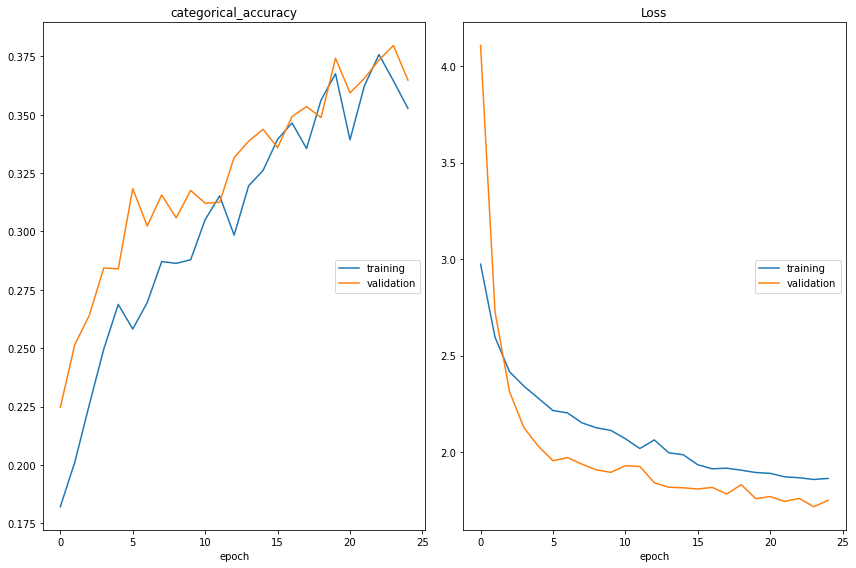

categorical_accuracy
	training         	 (min:    0.182, max:    0.376, cur:    0.353)
	validation       	 (min:    0.225, max:    0.380, cur:    0.365)
Loss
	training         	 (min:    1.857, max:    2.974, cur:    1.863)
	validation       	 (min:    1.716, max:    4.108, cur:    1.749)
20/20 [==============================] - 778s 40s/step - loss: 1.8628 - categorical_accuracy: 0.3527 - val_loss: 1.7494 - val_categorical_accuracy: 0.3648
Wall time: 5h 41min 49s


In [ ]:
%%time
history = model.fit( train_generator_1,
                      steps_per_epoch=80,
                      epochs = 30,
                      validation_data = test_generator_1,
                      validation_steps = 80,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback, 
                                   ],
                      class_weight=class_weight)

### MobileNet

In [ ]:
model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [ ]:
def preprocessing_image_mobilenet(image):
    image = (np.array(image).astype(float))/255 #convert to array and scale 0..255 to 0..1
    img = np.expand_dims(image, axis = 0)
    preprocessed_input = preprocess_input(img*255.)
    return img

In [ ]:
datagen = ImageDataGenerator(
#     preprocessing_function=preprocessing_image_mobilenet,
                            rescale=1./255, 
                            rotation_range=20,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.01,
                            zoom_range=0.1,
# #                           horizontal_flip=True,
                            fill_mode='nearest'
                            )

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=128)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


[0. 0. 0. 0. 1. 0. 0. 0. 0.]


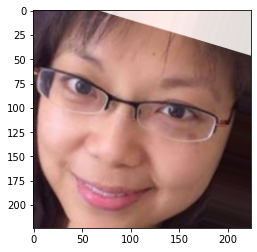

In [ ]:
sample = next(train_generator_1)
print(sample[1][3])
# print(np.split(sample[1][3].astype("float32"), 3, axis=1))
plt.imshow(sample[0][3])

In [ ]:
for layer in model.layers[:-14]:
    layer.trainable = False
 # Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000023D479E47C0> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x0000023D479E4940> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000023D43603F10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000023D435A9FA0> False
<keras.layers.core.tf_op_layer.TFOpLambda object at 0x0000023D3BEED9D0> False
<keras.layers.activation.relu.ReLU object at 0x0000023D438F5E20> False
<keras.layers.core.tf_op_layer.TFOpLambda object at 0x0000023D3BD46070> False
<keras.layers.merging.multiply.Multiply object at 0x0000023D45C60D00> False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000023D47A0F640> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000023D47A05D60> False
<keras.layers.activation.relu.ReLU object at 0x0000023D3C044C40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000023D3BD32280> False


In [ ]:
def get_compiled_model():
    # Create the model
    model_1 = models.Sequential()
    # Add the vgg convolutional base model
    model_1.add(model)

    # Add new layers
    model_1.add(tf.keras.layers.Flatten())
    model_1.add(tf.keras.layers.Dense(256, activation='relu'))   
    model_1.add(tf.keras.layers.Dropout(0.2))
    model_1.add(tf.keras.layers.Dense(9, activation='softmax'))
    
    model_1.compile(optimizer= 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])
    
    return model_1

In [ ]:
model_1=get_compiled_model()
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten_10 (Flatten)        (None, 47040)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               12042496  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 9)                 2313      
                                                                 
Total params: 15,041,161
Trainable params: 12,044,809
Non-trainable params: 2,996,352
_________________________________

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_mobilenet_augm.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

In [ ]:
%%time
history = model_1.fit( train_generator_1,
                      steps_per_epoch=200,
                      epochs = 50,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback, 
                                   early_stopping_callback
                                   ],
                      class_weight=class_weight)

### Inference

In [ ]:
def show_pred(images, labels, predicted_labels=None):
    plt.figure(figsize=(15,15))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = image.load_img(images[i])
        plt.imshow(img)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

In [ ]:
idxs = np.random.choice(np.arange(len(test_generator.filenames)), 1, replace=False)
fnames = []
labels = []
preds = []
for i in idxs:
    fnames.append('/content/drive/MyDrive/course_work_nn/train/' + test_generator_1.filenames[i])
    labels.append(list(set(df['emotion']))[test_generator.labels[i]])
    preds.append(list(set(df['emotion']))[np.argmax(predicted_labels[i])])
show_pred(fnames, labels, preds)

### One photo inference

In [ ]:
def preprocess_img(img):
    """препроцессинг фото перед подачей в сеть"""
    img = img.resize((128,128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    img = np.expand_dims(img, axis = 0)
    return img

In [ ]:
%%timeit -n 10 -r 10

img = image.load_img('C:/Users/Admin/Documents/курсовая_нейронка_эмоции/test_kaggle/test_kaggle/1.jpg')
img = preprocess_img(img)
pred = model01.predict(img)

### Generating a file for Kaggle

In [ ]:
shutil.rmtree('/content/drive/MyDrive/course_work_nn/test_kaggle')

In [ ]:
!cd /content/drive/MyDrive/course_work_nn/ && unzip -q test_kaggle.zip

In [ ]:
model01 = tf.keras.models.load_model('model_main3_imagenet_augm.h5')

In [ ]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']

In [ ]:
datagen = ImageDataGenerator(rescale = 1/255.)

In [ ]:
test_generator = datagen.flow_from_directory(directory = 'test_kaggle/test_kaggle/',
                                       target_size=(224,224),
                                       class_mode='categorical',
                                       classes=['.'],
                                       shuffle = False,
                                       batch_size=1)

Found 5000 images belonging to 1 classes.


In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

predictions = []
for i in pred:
    predictions.append(emotions[np.argmax(i)])


filenames = []
for i in test_generator.filenames:
    filn = i.replace(".\\",'')
    filenames.append(filn)

results=pd.DataFrame({"image_path":filenames,
                      "emotion":predictions})

<ipython-input-26-53b1dc6b37e3>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)


5000/5000 [==============================] - 1717s 343ms/step


In [ ]:
results.to_csv('model_imagenet_augm.csv', index=False)